In [174]:
#DO ALL PROCESS AT ONE TIME
from imp import reload 
import sys
from allProcess import *
reload(sys.modules['allProcess'])
from allProcess import *

IMG_LIST = ['facebook1']
IMG_LIST = list(range(6309,6318))
#((w1+h1>f*7) and (w2+h2>f*7))
for i in IMG_LIST:
    print('===========PROCESSING IMAGE NUMBER '+str(i)+'=============')
    allProcess(str(i), False)
    ##一般測試experiment設為false

===========PROCESSING IMAGE NUMBER 6309=============
image size:  2436 * 1125
lowThreshold, highThreshold, mean: 21 42 214.36486735997082
canny mean: 2.074334975369458
canny mean after dilate by 7 : 20.15630541871921
number of contour result: 50
number of contours after filted by hierarchy: 28
number of contours after filted by size: 27
number of contours after filted out img noises: 27
Logical Processors:  8
get text thickerround[0]Box[0]thread[4]: x=527, y=2209, w=70, h=70, confidence: 92, text: Qround[0]Box[0]thread[2]: x=750, y=2290, w=72, h=43, confidence: 96, text: 通知 [6, [8, 5, 7, -1]]

 round[0]Box[0]thread[6]: x=754, y=2208, w=65, h=71, confidence: 0, text: round[0]Box[0]thread[0]: x=525, y=2290, w=72, h=43, confidence: 95, text: 搜尋[2, [3, 1, -1, -1]] 
round[0]Box[0]thread[3]: x=75, y=2290, w=73, h=43, confidence: 93, text: 發現 [3, [4, 2, -1, -1]]
[8, [10, 6, 9, -1]]
 [5, [6, 4, -1, -1]]
round[0]Box[0]thread[1]: x=974, y=2290, w=73, h=43, confidence: 96, text: 我的 [1, [2, 0, -1,

get text thinner
round[0]Box[0]thread[7]: x=658, y=474, w=90, h=90, confidence: 85, text: > [80, [-1, -1, 81, 79]]
get text thicker
round[0]Box[0]thread[1]: x=892, y=586, w=183, h=54, confidence: 96, text: 播放紀錄 [71, [72, 70, -1, -1]]
get text thicker
round[0]Box[0]thread[6]: x=643, y=459, w=119, h=119, confidence: 45, text: @ [79, [82, 76, 80, -1]]
get text thicker
round[0]Box[0]thread[1]: x=96, y=474, w=90, h=90, confidence: 94, text: 回 [87, [-1, -1, 88, 86]]
get text thicker
round[0]Box[0]thread[3]: x=362, y=459, w=119, h=120, confidence: 50, text: @ [82, [86, 79, 83, -1]]
get text thicker
round[0]Box[0]thread[4]: x=355, y=2389, w=416, h=30, confidence: 14, text: De [0, [1, -1, -1, -1]]
get text thicker
round[0]Box[0]thread[4]: x=875, y=46, w=65, h=46, confidence: 0, text:  [99, [100, 96, -1, -1]]
round[0]Box[0]thread[6]: x=45, y=195, w=219, h=113, confidence: 96, text: 我的 [89, [96, 86, 90, -1]]
round[0]Box[0]thread[4]: x=70, y=45, w=139, h=48, confidence: 93, text: 03:55 [100, [101,

round[0]Box[0]thread[6]: x=303, y=2012, w=79, h=49, confidence: 96, text: the [33, [34, 31, -1, -1]]
round[0]Box[0]thread[6]: x=475, y=1943, w=79, h=49, confidence: 96, text: fireround[0]Box[0]thread[4]: x=205, y=2012, w=97, h=49, confidence: 96, text: with  [36, [37, 35, -1, -1]]
[34, [35, 33, -1, -1]]
round[0]Box[0]thread[5]: x=71, y=1945, w=129, h=55, confidence: 95, text: Hymnround[0]Box[0]thread[6]: x=388, y=1943, w=86, h=49, confidence: 97, text: and [37, [38, 36, -1, -1]] 
[35, [36, 34, -1, -1]]
round[0]Box[0]thread[4]: x=202, y=1943, w=185, h=49, confidence: 96, text: ofsweatround[0]Box[0]thread[3]: x=70, y=1875, w=134, h=48, confidence: 96, text: Green  [40, [41, 38, -1, -1]]
[38, [40, 37, 39, -1]]
round[0]Box[0]thread[3]: x=207, y=1874, w=45, h=48, confidence: 95, text: in [43, [44, 42, -1, -1]]
round[0]Box[0]thread[1]: x=468, y=1874, w=191, h=49, confidence: 95, text: ofdesire [41, [42, 40, -1, -1]]
round[0]Box[0]thread[4]: x=253, y=1874, w=214, h=58, confidence: 96, text: t

round[0]Box[0]thread[6]: x=572, y=1829, w=188, h=53, confidence: 95, text: 影子計劃 [37, [40, 36, 38, -1]]
round[0]Box[0]thread[3]: x=44, y=1829, w=235, h=53, confidence: 96, text: 乾淨的房間 [40, [41, 37, -1, -1]]
get text thinner
round[0]Box[0]thread[2]: x=676, y=1959, w=261, h=75, confidence: 84, text: +追蹤 [22, [-1, -1, 23, 21]]
get text thinner
round[0]Box[0]thread[5]: x=160, y=1959, w=261, h=75, confidence: 84, text: +追蹤 [26, [-1, -1, 27, 25]]
round[0]Box[0]thread[2]: x=970, y=1278, w=95, h=52, confidence: 96, text: 更多 [103, [105, 47, 104, -1]]
get text thinner
round[0]Box[0]thread[1]: x=666, y=1949, w=282, h=96, confidence: 59, text: 「round[0]Box[0]thread[2]: x=830, y=1000, w=101, h=43, confidence: 96, text: Jump [107, [108, 105, -1, -1]]
 [21, [25, 20, 22, -1]]
get text thinner
round[0]Box[0]thread[4]: x=150, y=1949, w=282, h=96, confidence: 59, text: 「 [25, [29, 21, 26, -1]]
round[0]Box[0]thread[1]: x=705, y=1000, w=122, h=44, confidence: 96, text: Mango [108, [109, 107, -1, -1]]
round[

round[0]Box[0]thread[5]: x=462, y=1071, w=88, h=51, confidence: 85, text: (P... [125, [126, 124, -1, -1]]
round[0]Box[0]thread[4]: x=964, y=945, w=94, h=94, confidence: 73, text: x [138, [140, 137, 139, 132]]
round[0]Box[0]thread[7]: x=92, y=1479, w=263, h=100, confidence: 92, text: 街聲熱推TOF 曲現在就跟上 [106, [111, 101, 107, 92]]
get text thicker
round[0]Box[0]thread[7]: x=536, y=388, w=18, h=22, confidence: 0, text:  [308, [309, 195, -1, -1]]
round[0]Box[0]thread[7]: x=445, y=325, w=29, h=41, confidence: 80, text: ? [310, [311, 309, -1, -1]]
get text thinner
round[0]Box[0]thread[4]: x=436, y=948, w=94, h=91, confidence: 59, text: 2G [201, [203, 200, 202, 195]]
round[0]Box[0]thread[4]: x=943, y=51, w=56, h=38, confidence: 95, text: 4G [330, [331, 329, -1, -1]]
get text thicker
round[0]Box[0]thread[4]: x=877, y=48, w=61, h=42, confidence: 0, text:  [331, [332, 330, -1, -1]]
round[0]Box[0]thread[4]: x=72, y=47, w=136, h=44, confidence: 94, text: 03:56 [332, [334, 331, 333, -1]]
get text thicke

round[0]Box[0]thread[5]: x=353, y=814, w=193, h=95, confidence: 91, text: 舉刀自盡 [95, [100, 94, 96, -1]]
get text thicker
round[0]Box[0]thread[6]: x=1006, y=670, w=46, h=21, confidence: 0, text:  [102, [103, 101, -1, -1]]
round[0]Box[0]thread[6]: x=65, y=462, w=61, h=46, confidence: 91, text: 42 [117, [118, 116, -1, -1]]
get text thicker
round[0]Box[0]thread[5]: x=1006, y=475, w=46, h=21, confidence: 0, text:  [116, [117, 108, -1, -1]]
round[0]Box[0]thread[3]: x=354, y=1398, w=559, h=98, confidence: 84, text: 不敢在夢裡面對夢醒的威受 [61, [67, 60, 62, -1]]
get text thicker
round[0]Box[0]thread[4]: x=355, y=2389, w=416, h=30, confidence: 14, text: De [0, [1, -1, -1, -1]]
round[0]Box[0]thread[4]: x=68, y=268, w=53, h=45, confidence: 86, text: 41 [134, [135, 133, -1, -1]]
round[0]Box[0]thread[2]: x=353, y=621, w=240, h=99, confidence: 73, text: RadicalLov igfiiCollage [105, [108, 104, 106, -1]]
get text thinner
round[0]Box[0]thread[1]: x=151, y=808, w=179, h=159, confidence: 34, text: 字 [100, [101, 95,

round[0]Box[0]thread[0]: x=329, y=179, w=150, h=56, confidence: 95, text: 歌曲或 [199, [201, 198, 200, 196]]
get text thinner
round[0]Box[0]thread[3]: x=42, y=345, w=501, h=288, confidence: 48, text: Tory Et [169, [195, 153, 170, -1]]
round[0]Box[0]thread[2]: x=42, y=138, w=1040, h=139, confidence: 74, text: QBA.歌曲或Podcast [195, [204, 169, 196, -1]]
get text thinner
round[0]Box[0]thread[4]: x=579, y=345, w=501, h=288, confidence: 66, text: 搖滾樂> 了 [153, [169, 141, 154, -1]]
get text thicker
round[0]Box[0]thread[7]: x=589, y=355, w=480, h=267, confidence: 67, text: 搖滾樂但 a [167, [-1, 166, 168, 153]]
get text thicker
round[0]Box[0]thread[5]: x=52, y=148, w=1020, h=119, confidence: 87, text: 0藝人、歌曲或Podcast [196, [-1, -1, 197, 195]]
took tot: 11.883955955505371
remove [[196, [-1, -1, 197, 195]], [52, 148, 1020, 119], ['0藝人、歌曲或Podcast', 87]]
remove [[195, [204, 169, 196, -1]], [42, 138, 1040, 139], ['QBA.歌曲或Podcast', 74]]
remove [[26, [55, 25, 27, -1]], [0, 1809, 1125, 382], ['©WaitingForTheSnow

In [176]:
import cv2
import numpy as np
from  matplotlib import pyplot as plt


IMAGE_NUMBER = str('6312')
#IMAGE_NUMBER = 'facebook'
# img = cv2.imread('iosScreenshot/IMG_'+IMAGE_NUMBER+'.png', 1)
# h,w,_ = img.shape
# img = cv2.resize(img, (int(w*0.5),int(h*0.5)))
# cv2.imwrite('iosScreenshot/IMG_'+IMAGE_NUMBER+'1.png', img)
# plt.figure(figsize=(50,25))
# plt.imshow(img)

image size:  2436 * 1125
lowThreshold, highThreshold, mean: 13 27 136.3764849480022
canny mean: 5.07320197044335
canny mean after dilate by 7 : 47.5112315270936
number of contour result: 102
number of contours after filted by hierarchy: 65
number of contours after filted by size: 64
number of contours after filted out img noises: 54


<Figure size 3600x1800 with 0 Axes>

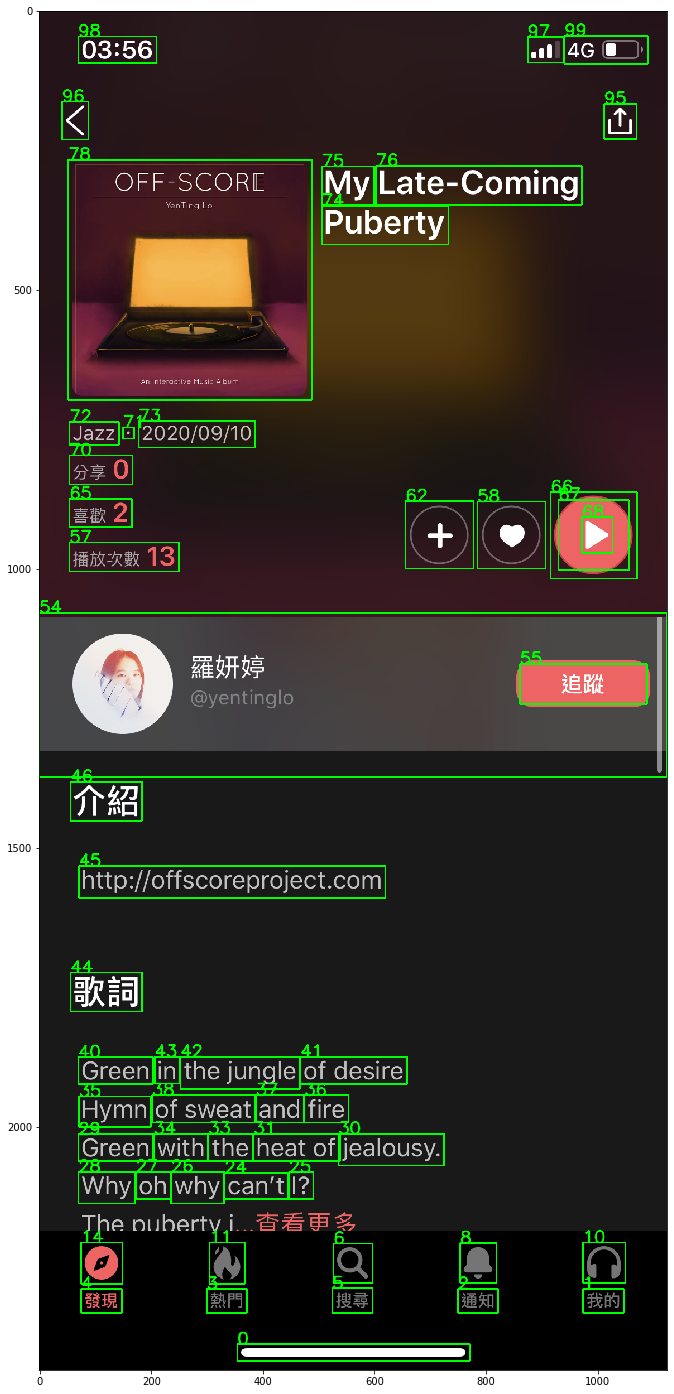

In [177]:
from getContourInfo import *
reload(sys.modules['getContourInfo'])
from getContourInfo import *

img = cv2.imread('iosScreenshot/IMG_'+IMAGE_NUMBER+'.png', 1)
#img = cv2.imread('experiment/'+IMAGE_NUMBER+'.png', 1)
height,width,_ = img.shape

print('image size: ', height, '*', width)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lowThreshold, highThreshold, mean = updateLowHighThreshold(gray)
print("lowThreshold, highThreshold, mean:",lowThreshold, highThreshold, mean)

blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)
gray_edges = cv2.Canny(blur_gray, lowThreshold, highThreshold)

mean_canny = np.average(gray_edges)
print('canny mean:',mean_canny)

if mean_canny<=7:
    i=7
elif 7<mean_canny<17:
    i=5
else:
    i=3

gray_edges = addDilate(gray_edges, i)
#加深edge
mean_canny = np.average(gray_edges)

print('canny mean after dilate by '+str(i)+' :',mean_canny)

cv2.imwrite('result/canny.jpg', gray_edges)

result, hierarchy, contourInfo = getContourInfo(gray_edges)

contourInfo = removeImgNoise(contourInfo, gray)
print('number of contours after filted out img noises:', len(contourInfo))

clone = img.copy()
for c in result:
    (x, y, w, h) = cv2.boundingRect(c)
    #if w>=30 and h>=30: 
    cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)
    #長方形框出contour

cv2.imwrite('result/'+IMAGE_NUMBER+'.png', clone)
plt.figure(figsize=(50,25))
clone = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
#matplotlib needs to change to rgb
#plt.imshow(clone)

#利用hierarchy 資訊篩選重要的contours
#print(result)
#print(len(hierarchy[0]))
#print(hierarchy[0])
#同層下一個輪廓的序號、同層上一個輪廓的序號、子輪廓的序號、父輪廓的序號。
#contourInfo: [[輪廓編號, 輪廓hier資訊],[輪廓座標]]
clone2 = img.copy()
for c in contourInfo:
    x,y,w,h = c[1]
    cv2.rectangle(clone2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(clone2, str(c[0][0]), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

cv2.imwrite('result/better_'+IMAGE_NUMBER+'.png', clone2)
plt.figure(figsize=(50,25))
clone2 = cv2.cvtColor(clone2, cv2.COLOR_BGR2RGB)
plt.imshow(clone2)

filt = [n for n in contourInfo if n[0][1][3]!=-1]
#篩選條件用
#print(filt)


Logical Processors:  8
round[0]Box[0]thread[4]: x=527, y=2209, w=70, h=70, confidence: 92, text: Qget text thicker 
[6, [8, 5, 7, -1]]
round[0]Box[0]thread[4]: x=754, y=2208, w=65, h=71, confidence: 0, text:  [8, [10, 6, 9, -1]]
round[0]Box[0]thread[3]: x=300, y=2290, w=72, h=43, confidence: 95, text: 熱門 [3, [4, 2, -1, -1]]
round[0]Box[0]thread[1]: x=974, y=2290, w=73, h=43, confidence: 96, text: 我的 [1, [2, 0, -1, -1]]
round[0]Box[0]thread[5]: x=75, y=2290, w=73, h=43, confidence: 93, text: 發現 [4, [5, 3, -1, -1]]
round[0]Box[0]thread[2]: x=750, y=2290, w=72, h=43, confidence: 96, text: 通知 [2, [3, 1, -1, -1]]
round[0]Box[0]thread[2]: x=236, y=2080, w=95, h=57, confidence: 96, text: why [26, [27, 25, -1, -1]]
round[0]Box[0]thread[4]: x=173, y=2080, w=62, h=49, confidence: 96, text: oh [27, [28, 26, -1, -1]]
round[0]Box[0]thread[6]: x=525, y=2289, w=72, h=44, confidence: 95, text: 搜尋 [5, [6, 4, -1, -1]]
round[0]Box[0]thread[4]: x=70, y=2080, w=102, h=57, confidence: 96, text: Why [28, [29

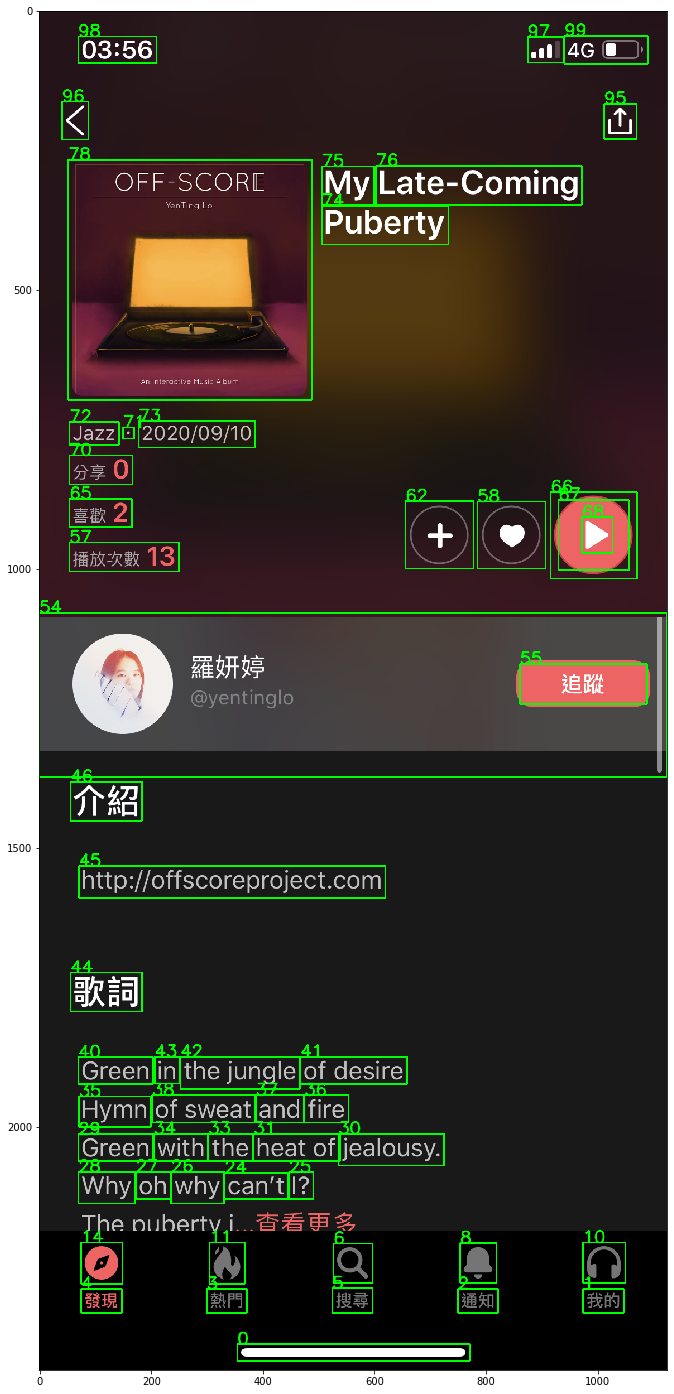

In [178]:
%%time
##辨識截圖上的文字並且加入contourInfo
## concurrent.futures version
from addText import *
reload(sys.modules['addText'])
from addText import *

import tesserocr
import pytesseract

from PIL import Image
import concurrent.futures
import queue

import time
import os

NUM_THREADS = os.cpu_count()
NUM_THREADS = 8
print('Logical Processors: ',NUM_THREADS)
#tesserocr_queue = queue.Queue()

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.fastNlMeansDenoising(img_gray)
#denoising


for t_num in range(NUM_THREADS):
    tesserocr_queue.put([t_num, tesserocr.PyTessBaseAPI(lang='eng+chi_tra',psm=6)])

start = time.time()

#from itertools import repeat
with concurrent.futures.ThreadPoolExecutor(NUM_THREADS) as executor:
    futures = {executor.submit(addText, c, img_gray): c for c in contourInfo}
    concurrent.futures.wait(futures)
#     futures = executor.map(addText, contourInfo, repeat(img_gray))
#     concurrent.futures.wait(futures)
    
    
end = time.time()
print('took tot: ' + str(end - start))
for _ in range(NUM_THREADS):
    t_num, api = tesserocr_queue.get(block=True)
    api.End()
    
    
clone3 = img.copy()
for c in contourInfo:
    x,y,w,h = c[1]
    cv2.rectangle(clone3, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(clone3, str(c[0][0]), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        

plt.figure(figsize=(50,25))
clone3 = cv2.cvtColor(clone3, cv2.COLOR_BGR2RGB)
plt.imshow(clone3)

##tesserocr: 
# img_crop = cv2.cvtColor(img_crop, cv2.COLOR_GRAY2RGB)
# pil_crop = Image.fromarray(img_crop)
# api.SetImage(pil_crop)
# ocrResult = api.GetUTF8Text()
# conf = api.MeanTextConf()

##pytesseract:
# ocr = pytesseract.image_to_data(img_crop,lang='eng+chi_tra',config='--psm 6', output_type='data.frame')
# text = ocr[ocr.conf != -1]
# lines = text.groupby('block_num')['text'].apply(list)[1]
# conf = text.groupby(['block_num'])['conf'].mean()[1]
# ocrResult = ''.join(lines)




0 [[0, [2, -1, 1, -1]], [357, 2391, 412, 27], ['De', 22]]
1 [[2, [3, 0, -1, -1]], [978, 2292, 67, 39], ['更多', 96]]
2 [[3, [4, 2, -1, -1]], [738, 2292, 97, 39], ['! 1l,', 52]]
3 [[4, [5, 3, -1, -1]], [528, 2292, 68, 38], ['收看', 96]]
4 [[5, [6, 4, -1, -1]], [304, 2292, 66, 39], ['比賽', 89]]
5 [[6, [7, 5, -1, -1]], [78, 2292, 68, 39], ['主場', 92]]
6 [[7, [8, 6, -1, -1]], [969, 2229, 84, 30], ['ooo', 85]]
7 [[8, [17, 7, 9, -1]], [285, 2208, 102, 72], ['E)>G', 0]]
8 [[17, [21, 8, 18, -1]], [734, 2205, 105, 78], ['口號', 72]]
9 [[21, [25, 17, 22, -1]], [519, 2202, 84, 84], ['C)', 57]]
10 [[22, [-1, -1, 23, 21]], [534, 2217, 54, 54], ['»', 77]]
11 [[23, [-1, -1, 24, 22]], [546, 2227, 33, 35], ['>', 75]]
12 [[25, [29, 21, 26, -1]], [69, 2202, 84, 84], ['|€|', 52]]
13 [[29, [42, 25, 30, -1]], [0, 2022, 1125, 171], ['', 0]]
14 [[42, [44, 29, 43, -1]], [26, 1940, 200, 56], ['精選故事', 87]]
15 [[44, [45, 42, -1, -1]], [1048, 1232, 77, 612], ['|', 90]]
16 [[45, [46, 44, -1, -1]], [32, 1183, 32, 25], ['~|'

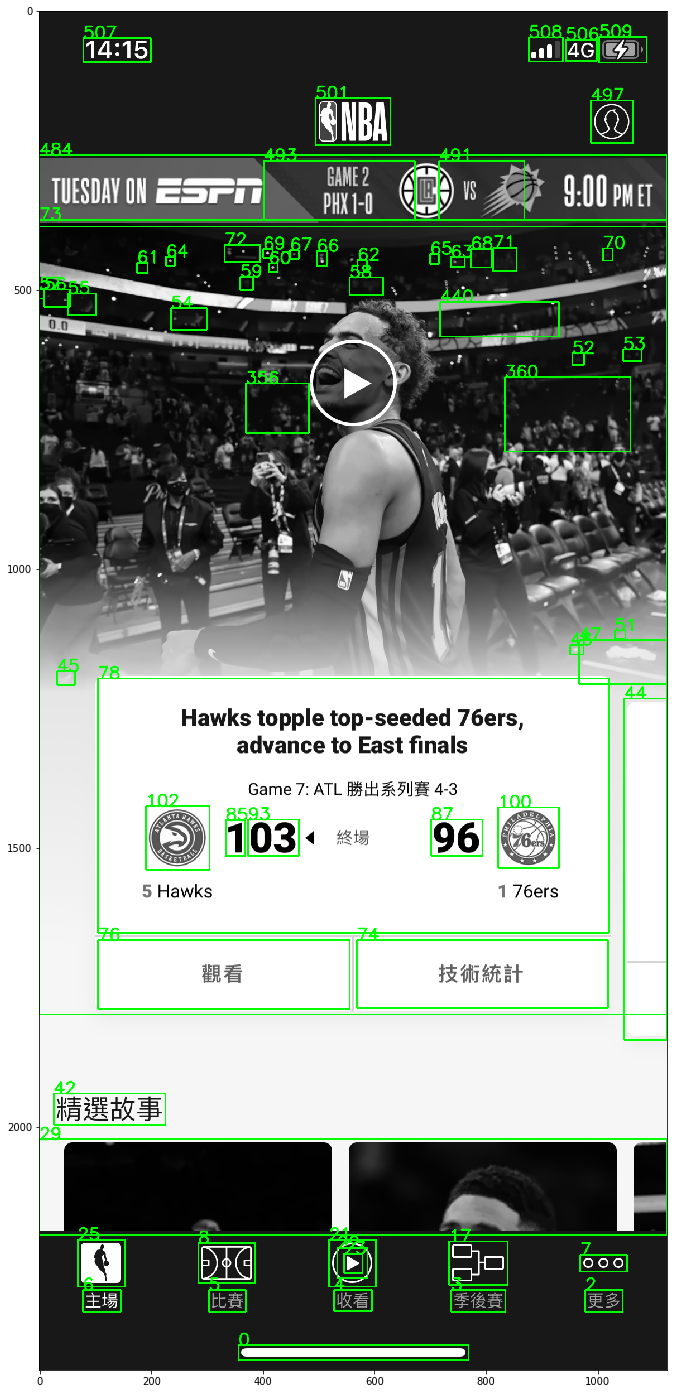

In [127]:
# import threading
# import multiprocessing as mp

# tesserocr.get_languages()
for i, c in enumerate(contourInfo):
    print(i, c)
# print(len(contourInfo))


# import concurrent.futures



# def say_hello_to(name):
#     print(name)
#     return f'Hi, {name}'


# names = ['John', 'Ben', 'Bill', 'Alex', 'Jenny'] * 10


# with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
#     results = {executor.submit(say_hello_to, name): name for name in names}
#     concurrent.futures.wait(results)
print(img.shape)
plt.figure(figsize=(50,25))
sss = cv2.cvtColor(img_gray.copy(), cv2.COLOR_BGR2RGB)
for c in contourInfo:
    x,y,w,h = c[1]
    cv2.rectangle(sss, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(sss, str(c[0][0]), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
plt.imshow(sss)

dilate
monty 66 [66]


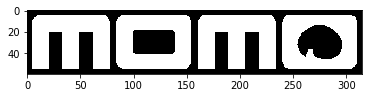

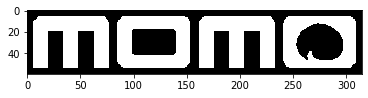

In [12]:
##ocr test for one contour
api = tesserocr.PyTessBaseAPI(lang='eng+chi_tra',psm=6)
img = cv2.imread('iosScreenshot/IMG_'+IMAGE_NUMBER+'.png', 1)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_gray = cv2.fastNlMeansDenoising(img_gray)
x,y,w,h = contourInfo[64][1]
# # x = int(x+0.02*w)
# # y = int(y+0.05*h)
# # w = int(0.96*w)
# # h = int(0.9*h)
flag=0
for j in range(1):
    ratio = [h/(h+w), w/(h+w)]
    s = 0.1*j*w if w>h else 0.1*j*h
    ratio = [int(s*k) for k in ratio]
    ##要設定s還是固定距離就好？？
    y_low = y-ratio[0] if y-ratio[0]>=0 else 0
    y_upp = y+h+ratio[0] if y+h+ratio[0]<img_gray.shape[0] else img_gray.shape[0]
    x_low = x-ratio[1] if x-ratio[1]>=0 else 0
    x_upp = x+w+ratio[1] if x+w+ratio[1]<img_gray.shape[1] else img_gray.shape[1]
    #img_crop = img_gray[y-ratio[0]:y+h+ratio[0], x-ratio[1]:x+w+ratio[1]].copy()
    img_crop = img_gray[y_low:y_upp, x_low:x_upp].copy()
    hc,wc = img_crop.shape
    if j==0: mean_crop = np.average(img_crop)
    if mean_crop <= 140:
        ret,img_crop = cv2.threshold(img_crop,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    else:
        ret,img_crop = cv2.threshold(img_crop,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    ##binarize

    if y_low!=0: 
        img_crop[0:ratio[0],:] = 255
        img_crop[ratio[0]+h:hc,:] = 255
    else: 
        img_crop[0:y,:] = 255
        img_crop[y+h:hc,:] = 255

    if x_low!=0: 
        img_crop[:,0:ratio[1]] = 255
        img_crop[:,ratio[1]+w:wc] = 255
    else: 
        img_crop[:,0:x] = 255
        img_crop[:,x+w:wc] = 255
    ##等比例拉遠並把外圍pixel設為255

    #img_crop = cv2.resize(img_crop, (int(wc*10),int(hc*10)))
    #圖片放大
    img_crop = cv2.cvtColor(img_crop, cv2.COLOR_GRAY2RGB)
    pil = Image.fromarray(img_crop)
    api.SetImage(pil)
    ocrResult = api.GetUTF8Text()
    conf = api.MeanTextConf()
    
    ##直接切割圖片後各自辨識
    


    if conf==0: flag+=1 
    else: flag=0
    if conf<=70:
        kernel = np.ones((3,3), np.uint8)
        img_crop_ero = cv2.erode(img_crop, kernel, iterations = 1)
        pil = Image.fromarray(img_crop_ero)
        api.SetImage(pil)
        ocrResult1 = api.GetUTF8Text()
        conf1 = api.MeanTextConf()
        


        img_crop_dil = cv2.dilate(img_crop, kernel, iterations = 1)
        pil = Image.fromarray(img_crop_dil)
        api.SetImage(pil)
        ocrResult2 = api.GetUTF8Text()
        conf2 = api.MeanTextConf()
        


        if conf1>=conf2:
            ocrResult = ocrResult1
            conf = conf1
            print('erode')
            plt.figure()
            plt.imshow(img_crop_ero)
        else:
            ocrResult = ocrResult2
            conf = conf2
            print('dilate')
            plt.figure()
            plt.imshow(img_crop_dil)
            ##辨識不出來就加粗字體or變細

        if conf==0: flag+=1 
        else: flag=0
    ocrResult = ocrResult.strip().replace(" ","").replace("\n"," ")   
    print(ocrResult,conf, api.AllWordConfidences())
    plt.figure()
    plt.imshow(img_crop)

    if conf>=95 or (conf>=80 and j>=3) or (conf>=70 and j>=10) or flag==4: pass

# plt.imshow(img_crop)






remove [[54, [57, 49, 55, -1]], [0, 1078, 1125, 294], ['羅妍婷', 80]]
before combine:  54
after combine1:  26
after combine2:  24
after remove overlap:  24
after remove overlap2:  24
[[97, [98, 96, -1, -1]], [875, 44, 215, 50], ['4G國,', 75]]
[[98, [99, 97, -1, -1]], [70, 45, 140, 48], ['03:56', 95]]
[[96, [97, 95, -1, -1]], [41, 162, 47, 68], ['<', 88]]
[[95, [96, 78, -1, -1]], [1012, 166, 58, 63], ['出', 71]]
[[78, [95, 76, 79, -1]], [52, 266, 436, 431], ['OFF-SCORE YenTingLo 之ro AnInteractiveMusicAlbum', 80]]
[[75, [76, 74, -1, -1]], [506, 277, 466, 70], ['Late-Coming My', 91]]
[[74, [75, 73, -1, -1]], [506, 349, 227, 69], ['Puberty', 96]]
[[57, [58, 54, -1, -1]], [54, 735, 333, 269], ['2020/09/10 Jazz', 96]]
[[66, [70, 65, 67, -1]], [916, 862, 155, 155], ['>', 92]]
[[62, [65, 58, 63, -1]], [656, 878, 122, 121], ['+', 96]]
[[58, [62, 57, 59, -1]], [785, 879, 122, 120], ['', 0]]
[[55, [-1, -1, 56, 54]], [861, 1170, 228, 72], ['追蹤', 82]]
[[46, [47, 45, -1, -1]], [56, 1381, 128, 70], ['介紹',

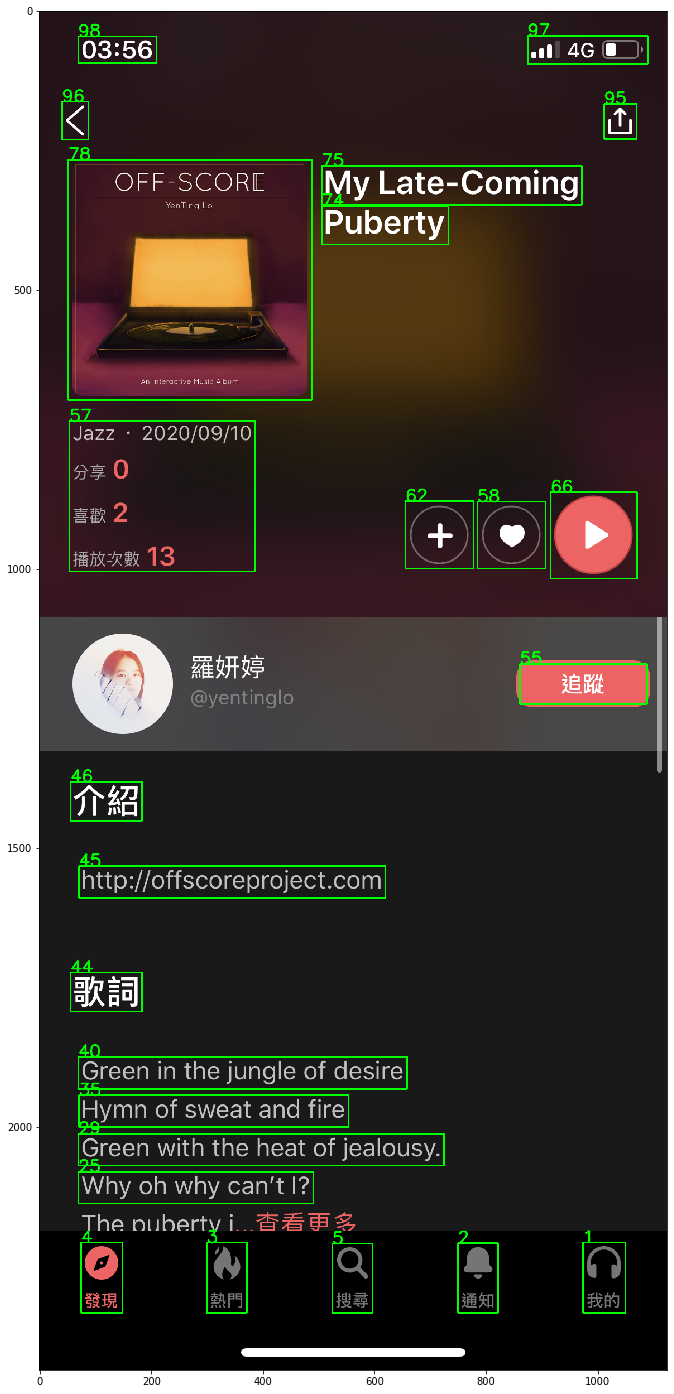

In [180]:
##c,d distance limitation
#d in c: upper left and (center or y_axis dist)
#c in d: upper left and (center or y_axis dist)
#d on right of c: (d's upper left - c's upper right) or (d's bottom left - c's bottom right) and (center or y_axis dist)
#d on left of c: (d's upper right - c's upper left) or (d's bottom right - c's bottom left)and (center or y_axis dist)
#d at top:(d's bottom left - c's upper left) or (d's bottom right - c's upper right) and center
#d at bottom:(d's upper left - c's bottom left) or (d's upper right - c's bottom right) and center

##combine contours that might be in the same element
#print(contourInfo)
#[[輪廓編號, 輪廓hier資訊],[x,y,w,h],[輪廓文字,confidence]]
import math 
from combineContour import *
reload(sys.modules['combineContour'])
from combineContour import *

sizeOG = img.shape
h,w,_ = img.shape
dist_factor = (w*0.01,h*0.01) if w<h else (h*0.01,w*0.01)
contourInfo_new = contourInfo.copy()
contourInfo_new.reverse()

        

contourInfo_new = combineContour(contourInfo_new, sizeOG)

print('before combine: ', len(contourInfo))
print('after combine1: ', len(contourInfo_new))
contourInfo_new = combineContour(contourInfo_new, sizeOG)
print('after combine2: ', len(contourInfo_new))

# contourInfo_new = combineContour(contourInfo_new, sizeOG)
# print('after combine3: ', len(contourInfo_new))

contourInfo_new = removeOverlap(contourInfo_new, sizeOG)
print('after remove overlap: ', len(contourInfo_new))
contourInfo_new = removeOverlap(contourInfo_new, sizeOG)
print('after remove overlap2: ', len(contourInfo_new))




clone4 = img.copy()
for i,c in enumerate(contourInfo_new):
    x,y,w,h = c[1]
    cv2.rectangle(clone4, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(clone4, str(c[0][0]), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)


cv2.imwrite('result/combined_'+IMAGE_NUMBER+'.jpg', clone4)
plt.figure(figsize=(50,25))
clone4 = cv2.cvtColor(clone4, cv2.COLOR_BGR2RGB)
plt.imshow(clone4)
for i in contourInfo_new:
    print(i)

In [158]:
f,l = dist_factor
print(f)
x1,y1,w1,h1= [978, 2292, 67, 39] #d
x2,y2,w2,h2 = [969, 2229, 84, 30]#c
x,y,w,h = [19, 1156, 834, 106]
mid_x1 = x1+(w1/2)
mid_y1 = y1+(h1/2)
mid_x2 = x2+(w2/2)
mid_y2 = y2+(h2/2)
center_dist = math.sqrt((mid_x1 - mid_x2)**2 + (mid_y1 - mid_y2)**2)
dtr_ctl = math.sqrt((x2 - (x1+w1))**2 + (y1 - y2)**2)
dbr_cbl = math.sqrt((x2 - (x1+w1))**2 + ((y1+h1) - (y2+h2))**2)
ctr_dtl = math.sqrt(((x2+w2) - x1)**2 + (y1 - y2)**2)
cbr_dbl = math.sqrt(((x2+w2) - x1)**2 + ((y1+h1) - (y2+h2))**2)

dbl_ctl = math.sqrt((x1 - x2)**2 + (y2 - (y1+h1))**2)
dbr_ctr = math.sqrt(((x1+w1) - (x2+w2))**2 + (y2 - (y1+h1))**2)
cbl_dtl = math.sqrt((x1 - x2)**2 + (y1 - (y2+h2))**2)
cbr_dtr = math.sqrt(((x1+w1) - (x2+w2))**2 + (y1 - (y2+h2))**2)

(cbl_dtl<=f*3.5 or cbr_dtr<=f*3.5 or ((w2<=w1 or abs(mid_x1-mid_x2)<=f) and (y1 - (y2+h2))<=f*3) or y1<y2+h2) \
and not((abs(h1/w1 - h2/w2)<=0.05 or (abs(h1/w1 - h2/w2)<=0.15 and h1+w1<=15*f) or (1<=w1/w2<=1.8 and 0<=h1-h2<=f) or (1<=w2/w1<=1.8 and 0<=h2-h1<=f)) and abs(h1+w1-(h2+w2))<=6.5*f and (h1/w1<=3 and w1/h1<=3) and (y1 - (y2+h2))>=f*0.5 and h1>=f*3 and w1>=f*3) \
and (abs(w1-w2)<f*22) and ((w1<f*21) or (w2<f*21)) \
and (abs(mid_x1-mid_x2)<=f*5 or (abs(x1-x2)<=f and abs(mid_x1-mid_x2)<=f*10) or (abs(x1+w1-(x2+h2))<=f and abs(mid_x1-mid_x2)<=f*10))

# not((abs(h1/w1 - h2/w2)<=0.05 or (abs(h1/w1 - h2/w2)<=0.15 and h1+w1<=15*f) or (1<=w1/w2<=1.8 and h1-h2<=f) or (1<=w2/w1<=1.8 and h2-h1<=f)) and abs(h1+w1-(h2+w2))<=6.5*f and (h1/w1<=3 and w1/h1<=3) and (y1 - (y2+h2))>=f*0.5 and h1>=f*3 and w1>=f*3)

# (1<=w1/w2<=1.8 and 0<=h1-h2<=f) or (1<=w2/w1<=1.8 and 0<=h2-h1<=f)


# h1-h2


11.25


True

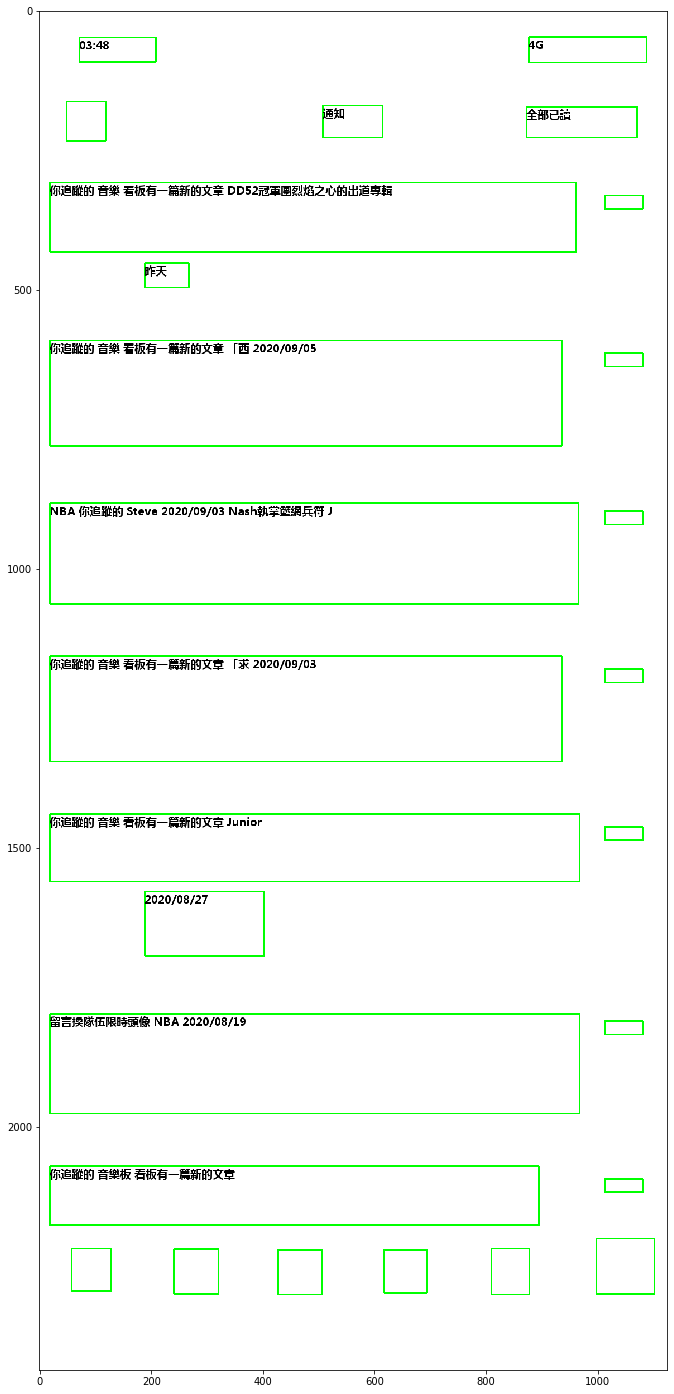

In [119]:
from PIL import Image, ImageDraw, ImageFont
clone5 = img.copy()
clone5[:][:][:] = 255
sym = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~©®'
alpha = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"

for i, c in enumerate(contourInfo_new):
    x,y,w,h = c[1]
    cv2.rectangle(clone5, (x, y), (x + w, y + h), (0, 255, 0), 2)
    #cv2.putText(clone5, c[2][0], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

clone5 = cv2.cvtColor(clone5, cv2.COLOR_BGR2RGB)
pil5 = Image.fromarray(clone5)
for i, c in enumerate(contourInfo_new):
    x,y,w,h = c[1]
    if c[2][1] >=70 and \
        not(not(False in (s in sym for s in c[2][0])) \
        or (not(False in (s in alpha+sym for s in c[2][0])) and len(c[2][0])<=2) \
        or len(c[2][0])<=1 or c[2][0]==len(c[2][0])*c[2][0][0]):
        draw = ImageDraw.Draw(pil5)
        fontText = ImageFont.truetype('msyhbd.ttf' , 20, encoding="utf-8")
        draw.text((x, y), c[2][0], (0, 0, 0), font=fontText)


pil5.save('result/contour&text_'+IMAGE_NUMBER+'.jpg')
plt.figure(figsize=(50,25))
plt.imshow(pil5)


27
172 [173, 171, -1, -1] [877, 46, 211, 46]
text:  ['4G', 95]
173 [175, 172, 174, -1] [72, 47, 137, 44]
text:  ['03:48', 94]
168 [171, 166, 169, -1] [49, 162, 70, 70]
166 [168, 163, 167, -1] [508, 169, 107, 57]
text:  ['通知', 96]
163 [166, 156, 164, -1] [873, 171, 198, 55]
text:  ['全部已讀', 94]
138 [139, 137, -1, -1] [19, 307, 943, 124]
text:  ['你追蹤的 音樂 看板有一篇新的文章 DD52冠軍團烈焰之心的出道專輯', 95]
148 [149, 146, -1, -1] [1013, 330, 68, 24]
136 [137, 129, -1, -1] [189, 451, 79, 44]
text:  ['昨天', 96]
117 [118, 116, -1, -1] [19, 590, 917, 189]
text:  ['你追蹤的 音樂 看板有一篇新的文章 「西 2020/09/05', 95]
122 [123, 120, -1, -1] [1013, 613, 68, 24]
96 [97, 95, -1, -1] [19, 882, 947, 180]
text:  ['NBA 你追蹤的 Steve 2020/09/03 Nash執掌籃網兵符 J', 95]
107 [108, 105, -1, -1] [1013, 896, 68, 24]
76 [77, 69, -1, -1] [19, 1156, 917, 189]
text:  ['你追蹤的 音樂 看板有一篇新的文章 「求 2020/09/03', 95]
81 [82, 79, -1, -1] [1013, 1179, 68, 24]
54 [55, 53, -1, -1] [19, 1439, 949, 121]
text:  ['你追蹤的 音樂 看板有一篇新的文章 Junior', 95]
63 [64, 61, -1, -1] [1013, 146

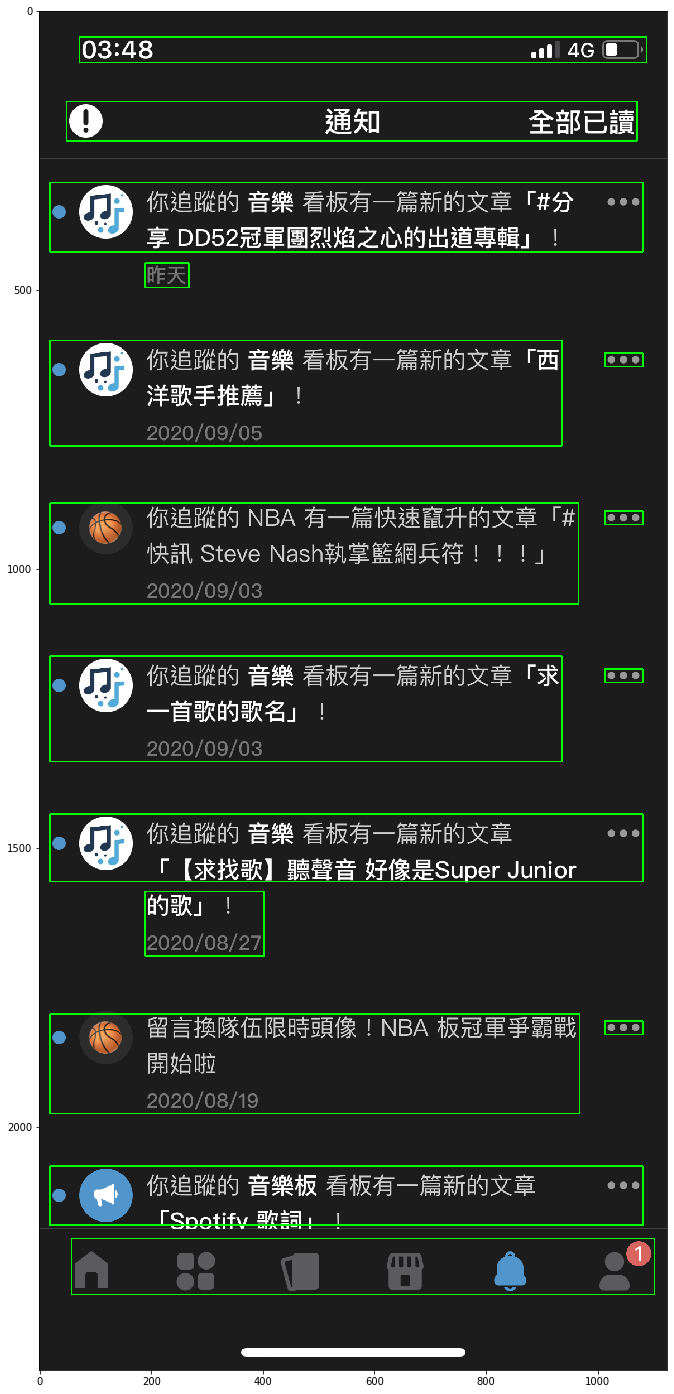

In [120]:
##產生截圖contour hierarchy的dict
import json
from generateDict import *
reload(sys.modules['generateDict'])
from generateDict import *


# with open('facebook.json', 'r') as fp:
#     j = json.load(fp)

# with open('facebook.json', 'w') as fp:
#     json.dump(j, fp, indent=4)

clone6 = img.copy()
mainDict, temp = generateJsonDict('test.json',img, contourInfo_new, sizeOG,clone6)
print('temp length: ', len(temp))

#clone6 = img.copy()
for i,c in enumerate(temp):
    x,y,w,h = c
    #cv2.rectangle(clone6, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.figure(figsize=(50,25))
clone6 = cv2.cvtColor(clone6, cv2.COLOR_BGR2RGB)
plt.imshow(clone6)

# generateXML('test.xml',img, contourInfo) 

********
number of contour result: 178
number of contours after filted by hierarchy: 92
number of contours after filted by size: 90
number of contours after filted out img noises: 90
Add Text Info
number of contours after combination:  32
number of contours after removed overlapping:  27
Write to dict
The all vision Dict!
********
CPU times: user 21.8 s, sys: 692 ms, total: 22.5 s
Wall time: 12.6 s


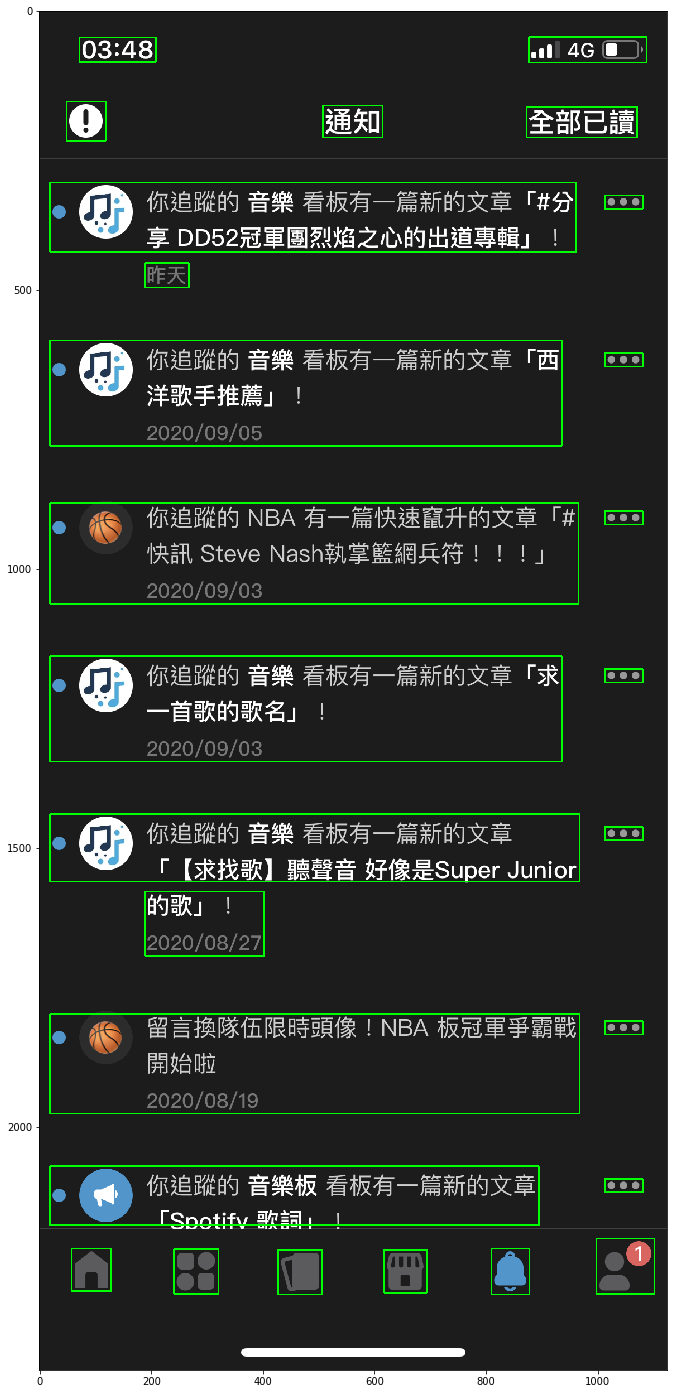

In [121]:
%%time
##class test
import cv2
from  matplotlib import pyplot as plt
from screenImageAnalyzer_test import screenImageAnalyzer
reload(sys.modules['screenImageAnalyzer_test'])
from screenImageAnalyzer_test import screenImageAnalyzer

img = cv2.imread('iosScreenshot/IMG_6301.png', 1)
cl = screenImageAnalyzer()
img = cl.getImage(img)
conDict, canvas, contours = cl.getVisionDict()

plt.figure(figsize=(50,25))
canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
plt.imshow(canvas)

In [117]:
import json
print(json.dumps(conDict, indent=4))
print(conDict)
for i,c in enumerate(contours):
    x,y,w,h = c[1]
    print(c)
    

{
    "_EA@isEnabled": true,
    "_EA@class": "XCUIElementTypeOther",
    "_EA@isHidden": false,
    "_EA@isClickable": false,
    "tag": "ol",
    "_TaaD::byVision": true,
    "x": 0,
    "y": 0,
    "width": 1125,
    "height": 2436,
    "child": [
        {
            "_EA@isEnabled": true,
            "_EA@class": "XCUIElementTypeOther",
            "_EA@isHidden": false,
            "_EA@isClickable": false,
            "tag": "li",
            "_TaaD::byVision": true,
            "x": 72,
            "y": 46,
            "width": 1016,
            "height": 46,
            "child": [
                {
                    "_EA@isEnabled": true,
                    "_EA@class": "XCUIElementTypeButton",
                    "_EA@isHidden": false,
                    "_EA@isClickable": true,
                    "tag": "button",
                    "op": "click",
                    "_TaaD::byVision": true,
                    "x": 877,
                    "y": 46,
                   

In [667]:
import copy
q = [1,2,3,4,5,6,7,[8]]
p = q.copy()
p = p.copy()

for c in p:
    if c==[8]:
        c.append(10)
        p.remove(c)
        

print(q)   
print(p)

for a,b in zip([1,2],[3,4]):
    print(a,b)

[1, 2, 3, 4, 5, 6, 7, [8, 10]]
[1, 2, 3, 4, 5, 6, 7]
1 3
2 4


In [482]:
unique, counts = np.unique(img_gray, return_counts=True)
print(max(counts),len(counts),len(unique))
unique

479401 256 256


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [683]:
a = [1,2,3,4,5]
# while len(a)>0:
#     c = a[0]
#     print('c',c)
#     for d in a[1:4]:
#         print('d',d)
#         a.remove(d)
#     a.remove(c)
    
for d in a:
    print(d)
    if d>2:
        a.remove(d)

s = [1,[2],3,[4],[4]]
s = set(tuple(s))
print(list(s))

1
2
3
5


TypeError: unhashable type: 'list'

In [66]:
a = [1,1,2,2,3,4]
print(True in (i in [1,3,2] for i in a) or True in (i==2 for i in a))

True
